# Example: PyRayHF Cartesian Gradient Raytracing

### Background: Ray Equations in a Plasma

Unlike Snell’s law approaches (which assume stratification and mirror the up-leg to construct the down-leg), the **gradient-based method** solves the full **ray equations** in Cartesian geometry:

- **Ray position**: $r = (x, z)$ [km]
- **Unit tangent vector**: $v = (vx, vz)$ with $||v||$ = 1
- **Arc length**: $s$ [km]
- **Refractive index field**: $n(x, z) = μ$ (phase index)

The equations of motion are:
$$
dr/ds = v
$$
$$
dv/ds = (1/n) [ ∇n − (∇n · v) v ]
$$


This form ensures that the velocity vector v remains normalized, and the ray bends naturally according to the spatial gradients of μ.

---

### Specifics in PyRayHF

- Geometry (bending) uses the **phase index $μ$**
- Group delay integrates the **group index $μ$'** (mup) if provided via `mup_func`
- The refractive index and its gradients are supplied by `build_refractive_index_interpolator`
- Cartesian geometry assumes a **flat Earth** (no curvature effects)
- Termination conditions stop the ray when it:
  - Reaches the ground
  - Leaves the vertical or horizontal domain
  - Exceeds maximum arc length

This method is more general than Snell’s law since it handles arbitrary 2-D gradients, not only stratified profiles.


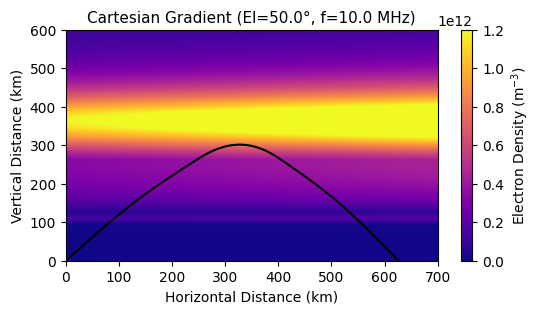

--------------------------------------------------
Gradient-based raytracing in a medium with gradient:
--------------------------------------------------
Group Path (km):  885.8923544825251
Group delay (sec):  0.0033971024470243784
Ground_ Range (km):  626.4213504381516
x midpoint (km):  330.89411071977264
z midpoint (km):  301.4142816606417
--------------------------------------------------
Elapsed time (sec):  0.3801304241642356
--------------------------------------------------


In [1]:
#!/usr/bin/env python
import numpy as np
import pickle
import matplotlib.pyplot as plt
from PyRayHF.library import find_X, find_Y, find_mu_mup
from PyRayHF.library import build_refractive_index_interpolator_cartesian
from PyRayHF.library import trace_ray_cartesian_gradient
from PyRayHF.library import build_mup_function
import time

# Directory on your local machine where to save the figures
local_dir = '/Users/vmakarevich/Documents/GitHub/PyRayHF/docs/figures/'

# Load an ionospheric profile
# See Example_Generate_Input_Arrays for how to create this input file using
# PyIRI.
file_open = 'Example_input.p'
input_arrays = pickle.load(open(file_open, 'rb'))
alt_km = input_arrays["alt"]
Ne = input_arrays["den"]
Babs = input_arrays["bmag"]
bpsi = input_arrays["bpsi"]

# Ensure ground level is included
h_ground = 0
if alt_km[0] > h_ground:
    Ne0 = np.interp(h_ground, alt_km, Ne)
    Babs0 = np.interp(h_ground, alt_km, Babs)
    bpsi0 = np.interp(h_ground, alt_km, bpsi)
    alt_km = np.insert(alt_km, 0, h_ground)
    Ne = np.insert(Ne, 0, Ne0)
    Babs = np.insert(Babs, 0, Babs0)
    bpsi = np.insert(bpsi, 0, bpsi0)

# Define inputs
elevation_deg = 50.
f0_Hz = 10e6
mode = "O"

# Create 2D density grid (Ne assumed horizontally uniform)
nx = 500
xmax = 1000
x_grid = np.linspace(0, xmax, nx)
z_grid = alt_km
Xg, Zg = np.meshgrid(x_grid, z_grid)
Ne_grid = np.tile(Ne[:, np.newaxis], (1, nx))
Babs_grid = np.tile(Babs[:, np.newaxis], (1, nx))
bpsi_grid = np.tile(bpsi[:, np.newaxis], (1, nx))

# Add some gradient to it
Ne_gradient = Ne_grid * (1.0 + 0.5 * (Xg / Xg.max()))

# Start the timer to time the code
start_time = time.perf_counter()

# Calculate plasma parameters
X = find_X(Ne_gradient, f0_Hz)
Y = find_Y(f0_Hz, Babs_grid)

mu, mup = find_mu_mup(X, Y, bpsi_grid, mode)
mup = np.where((mup < 1e-3) | np.isnan(mup), np.nan, mup)
mup0 = mup[0]

# Build interpolator from mup grid (validated)
n_and_grad = build_refractive_index_interpolator_cartesian(z_grid, x_grid, mu)

# Build μ' (group) for delay only
mup_func_cartesian = build_mup_function(mup_field=mup,
                                        x_grid=x_grid,
                                        z_grid=z_grid,
                                        geometry="cartesian")

# Raytrace
result = trace_ray_cartesian_gradient(n_and_grad=n_and_grad,
                                      x0_km=0.0,
                                      z0_km=0.0,
                                      elevation_deg=elevation_deg,
                                      s_max_km=4000.0,
                                      max_step_km=5.0,
                                      z_max_km=600.0,
                                      x_min_km=0.0,
                                      x_max_km=1000.0,
                                      mup_func=mup_func_cartesian)
# Stop the timer
end_time = time.perf_counter()
# Calculate and print the elapsed time
elapsed_time = end_time - start_time

# Plot results
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 3)
ax_plot = ax
ax_plot.set_xlim(0, 700)
ax_plot.set_ylim(0, 600)
ax_plot.set_facecolor("lightgray")
ax_plot.set_ylabel('Vertical Distance (km)')
ax_plot.set_xlabel('Horizontal Distance (km)')
vmin = 0
vmax = 1.2e12
color_ticks = np.arange(vmin, vmax + 2e11, 2e11)
pc = ax_plot.pcolormesh(Xg, Zg, Ne_gradient, shading='auto',
                        cmap='plasma', vmin=vmin, vmax=vmax)
ax_plot.plot(result['x'], result['z'], c='black')
ax_plot.set_title(f"Cartesian Gradient (El={elevation_deg:.1f}°, f={f0_Hz/1e6} MHz)", fontsize=11)
plt.colorbar(pc, label='Electron Density (m$^{-3}$)', ax=ax_plot,
             ticks=color_ticks)
plt.savefig(local_dir + 'Cartesian_Gradient.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
 
# Print diagnostics
print('--------------------------------------------------')
print('Gradient-based raytracing in a medium with gradient:')
print('--------------------------------------------------')
print('Group Path (km): ', result['group_path_km'])
print('Group delay (sec): ', result['group_delay_sec'])
print('Ground_ Range (km): ', result['ground_range_km'])
print('x midpoint (km): ', result['x_midpoint'])
print('z midpoint (km): ', result['z_midpoint'])

print('--------------------------------------------------')
print('Elapsed time (sec): ', elapsed_time)
print('--------------------------------------------------')